In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings('ignore')

In [221]:
data = pd.read_excel("Estimate_power.xlsx")
data.head()

,hour,unit_no,fuel_type,mvar,temp,moisture,power
0,1,1,A,22,3,94,250
1,2,1,A,23,3,96,250
2,3,1,A,23,2,95,250
3,4,1,A,25,2,95,251
4,5,1,A,26,2,95,252


In [222]:
data=data[data["power"]>100]
data.shape

(999, 7)

In [223]:
# Change object to integer:
data["fuel_type"][data["fuel_type"]=="A"] = 1; 
data["fuel_type"][data["fuel_type"]=="B"] = 2;
data["fuel_type"][data["fuel_type"]=="C"] = 3;

In [224]:
data['fuel_type'].value_counts()

1    711
Name: fuel_type, dtype: int64

In [225]:
data["fuel_type"].fillna(method='bfill', inplace=True)

In [226]:
data.isnull().sum()

hour         0
unit_no      0
fuel_type    0
mvar         0
temp         0
moisture     0
power        0
dtype: int64

In [227]:
X = data[["moisture","unit_no","temp","fuel_type"]]
y = data[["power"]]
y

,power
0,250
1,250
2,250
3,251
4,252
...,...
994,224
995,240
996,238
997,236


In [228]:
X

,moisture,unit_no,temp,fuel_type
0,94,1,3,1
1,96,1,3,1
2,95,1,2,1
3,95,1,2,1
4,95,1,2,1
...,...,...,...,...
994,6,6,15,1
995,8,6,16,1
996,21,6,18,1
997,11,6,19,1


In [229]:
data.isnull().sum()

hour         0
unit_no      0
fuel_type    0
mvar         0
temp         0
moisture     0
power        0
dtype: int64

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [231]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [232]:
# Training the Decision Tree Regression model on the whole dataset
model = ElasticNet()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [233]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 1326.3584181309668
R-squared: -16.352815735410477


# Tuning the hyperparameters

### with GridSearchView

In [234]:
# Define the SVR model
model1 = ElasticNet()

# Define the hyperparameters to tune
param_grid = {'alpha': np.logspace(-4, 4, 100),
              'l1_ratio': np.linspace(0, 1, 100)}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(model1, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 0.6280291441834259, 'l1_ratio': 1.0}
Best score: 0.10601360590429205


In [235]:
regressor =ElasticNet(**grid_search.best_params_)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)

In [237]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 1297.584870675899
R-squared: -7.468666803766547


### with RandomizedSearchCV

In [238]:
model2 = ElasticNet()
search = RandomizedSearchCV(model2, param_grid, cv=5, n_iter=50, random_state=42)

In [239]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=50,
                   param_distributions={'alpha': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2....
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ])},
                   random_state=42)

In [240]:
print("Best hyperparameters: ", search.best_params_)
print("Best score: ", search.best_score_)

Best hyperparameters:  {'l1_ratio': 0.9090909090909092, 'alpha': 0.1176811952434999}
Best score:  0.1043621519403362


In [241]:
regressor =ElasticNet(l1_ratio=0.9090909090909092,alpha= 0.1176811952434999)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)

In [242]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 1297.1345591749018
R-squared: -6.726348708920272


# Trying dimension reduction for the model

### PCA

In [243]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

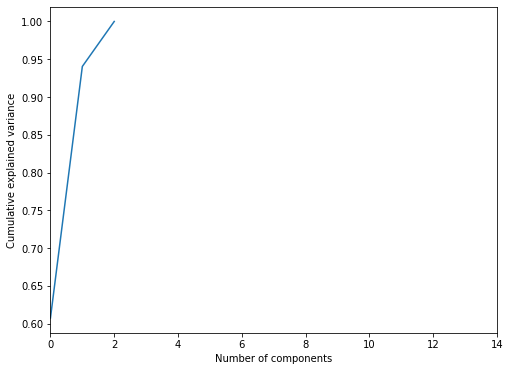

In [244]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

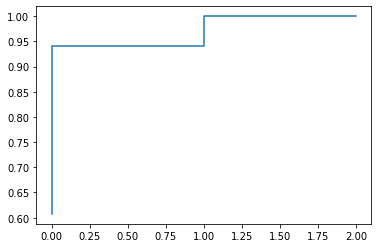

In [245]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

In [246]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()


[0.60743787 0.33298391 0.05957821 0.        ]



In [249]:
pipeline = Pipeline([
    ('pca', PCA(n_components=4)),
    ('el', ElasticNet(**grid_search.best_params_))
])

In [250]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [251]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 1302.307692991843
R-squared: -7.667545555360521


### t-SNE

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [253]:
tsne = TSNE(n_components=3, random_state=42)

In [254]:
X_train = tsne.fit_transform(X_train)
X_test = tsne.fit_transform(X_test)

In [255]:
regressor =ElasticNet(l1_ratio=0.9090909090909092,alpha= 0.1176811952434999)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)

In [256]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 1296.1269042710564
R-squared: -15.262516965624865
